In [1]:
1+1

2

In [2]:
import pandas as pd 

df = pd.read_csv('/workspace/wandb_export_2024-12-07T22_08_44.969-05_00.csv')
df

,dist,mean_loss,count,step_num
0,1,6.018883,838,0
1,2,6.023136,838,0
2,3,6.027907,834,0
3,4,6.021605,830,0
4,5,6.021239,830,0
...,...,...,...,...
24268,30,4.863709,2,42600
24269,31,5.453972,2,42600
24270,32,5.475689,2,42600
24271,33,5.844126,2,42600


Text(0.5, 1.0, 'Run 1k again. 60M, fp16')

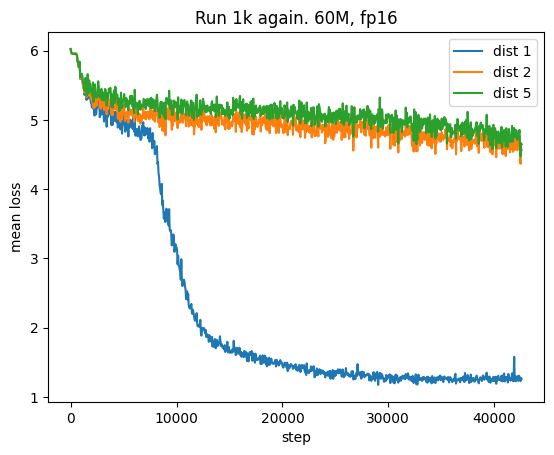

In [22]:
import matplotlib.pyplot as plt 

plt.plot(df[df['dist'] == 1]['step_num'], df[df['dist'] == 1]['mean_loss'], label='dist 1')
plt.plot(df[df['dist'] == 2]['step_num'], df[df['dist'] == 2]['mean_loss'], label='dist 2')
plt.plot(df[df['dist'] == 5]['step_num'], df[df['dist'] == 5]['mean_loss'], label='dist 5')
# plt.plot(df[df['dist'] == 10]['step_num'], df[df['dist'] == 10]['mean_loss'])
# plt.plot(df[df['dist'] == 30]['step_num'], df[df['dist'] == 30]['mean_loss'])
plt.legend()
plt.xlabel("step")
plt.ylabel("mean loss")
plt.title("Run 1k again. 60M, fp16")

In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
from utils.data_utils import load_recording
from utils.data_utils import plot_first_n, plot_spec
import torch
from tqdm import tqdm
import yaml
from models.bendr import EncoderConv, ContextNetwork

with open('configs/od_config_bendr.yaml', 'r') as file:
        cfg = yaml.safe_load(file)


encoder_sd = torch.load('/root/checkpoints/encoder_2024-12-07T23:52:29.345538.pt', map_location=torch.device('cpu') )
context_network_sd = torch.load('/root/checkpoints/context_network_2024-12-07T23:52:29.345538.pt', map_location=torch.device('cpu') )


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)
encoder.eval()
context_network.eval()

/tmp/ipykernel_53320/799723249.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sd = torch.load('/root/checkpoints/encoder_2024-12-07T23:52:29.345538.pt', map_lo

ContextNetwork(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-19): 20 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (target_proj): Linear(in_features=512, out_features=512, bias=True)
  (positional_emb): SinusoidalPositionalEncoding(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
  )
)

In [3]:
from dataset.labeled_dataset import EEGLabeledDataset
from torch.utils.data import DataLoader

dataset = EEGLabeledDataset(
    data_path='/root/neural_data/full_clean/h5',
    cache_processed_path='/root/neural_data/full_clean/cache/',
    train_length=73728, dataset_mode="full",
    rebuild_cache=False, limit=None,
    target_config={
    "user_id": True,
    "activity": False, },
    clipped_threshold=100
)
loader = DataLoader(dataset, 32, shuffle=True, drop_last=False)
next(iter(loader))['data'].shape


torch.Size([32, 4, 73728])

In [4]:
from tqdm import tqdm

vecs = []
uids = []

device = torch.device('cuda')
encoder = encoder.to(device)
context_network = context_network.to(device)

with torch.no_grad():
    for batch in tqdm(loader):
        batch['data'] = batch['data'].to(device)
        batch = encoder(batch)
        batch = context_network(batch, run_full=True)
        uids.extend(batch['user_id'].tolist())
        vecs.append(batch['full_context_vectors'].mean(1).cpu())

vecs = torch.cat(vecs, 0)
uids = torch.tensor(uids)

100%|██████████| 27/27 [00:06<00:00,  4.13it/s]


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import torch
import time
import numpy as np


def evaluate_logistic_regression(X, y, mode, do_norm):
    if do_norm:
        X = X / torch.norm(X, dim=1, keepdim=True)
    X, y = X.numpy(), y.numpy()
    prm = np.random.permutation(y.shape[0])
    X, y = X[prm, :], y[prm]
    
    model = LogisticRegression(max_iter=1000, n_jobs=-1)
    if mode == "self":
        model.fit(X, y)
        y_pred = model.predict(X)
        return accuracy_score(y, y_pred)
    elif mode == 'cv':
        accuracies = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
        return np.mean(accuracies)
    else:
        assert False
        
evaluate_logistic_regression(vecs, uids, mode='cv', do_norm=True)

0.18823529411764706

In [6]:
norm_vecs = vecs / torch.norm(vecs, dim=1, keepdim=True)

In [15]:
from catboost.utils import create_cd

create_cd(label=None,
          cat_features=None,
          text_features=None,
          embedding_features=range(512),
          weight=None,
          baseline=None,
          doc_id=None,
          group_id=None,
          subgroup_id=None,
          timestamp=None,
          auxiliary_columns=None,
          feature_names=None,
          output_path='train.cd')

In [44]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
import csv


def train_catboost_with_cv(X: torch.Tensor, y: torch.Tensor, n_splits: int = 5):
    """
    Trains a CatBoost classifier using embeddings and categorical targets with 5-fold cross-validation.

    Parameters:
        X (torch.Tensor): Input features of shape (n, emb_dim).
        y (torch.Tensor): Categorical targets of shape (n).
        n_splits (int): Number of folds for cross-validation (default is 5).

    Returns:
        dict: A dictionary containing the fold indices, trained models, and validation accuracies.
    """
    # Convert PyTorch tensors to numpy arrays

    with open('pool.cd', 'w') as f:
        f.write(
            '0\tLabel\n'\
            '1\tNumVector\n'
        )

    # Initialize cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {
        'fold_indices': [],
        'models': [],
        'accuracies': []
    }
    X_np = X.numpy()
    y_np = y.numpy()

    # Iterate through each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):

    # Save the dataset for CatBoost with embeddings
        with open('train_embed.tsv', 'w') as f:
            writer = csv.writer(f, delimiter='\t', quotechar='"')
            for y_row, row in zip(y_np[train_idx], X_np[train_idx]):
                writer.writerow((str(y_row), ';'.join(map(str, row))))
                
        with open('val_embed.tsv', 'w') as f:
            writer = csv.writer(f, delimiter='\t', quotechar='"')
            for y_row, row in zip(y_np[val_idx], X_np[val_idx]):
                writer.writerow((str(y_row), ';'.join(map(str, row))))
        
        print(f"Starting fold {fold_idx + 1}...")

        train_pool = Pool(
            data='/workspace/neural_foundation/src/train_embed.tsv', 
            column_description='/workspace/neural_foundation/src/pool.cd')
        
        val_pool = Pool(
            data='/workspace/neural_foundation/src/val_embed.tsv', 
            column_description='/workspace/neural_foundation/src/pool.cd')
        # val_pool = Pool(data=X_np[val_idx], label=y_np[val_idx], embedding_features=list(range(X_np.shape[1])), column_description='train.cd')

        # Initialize CatBoost classifier
        model = CatBoostClassifier(
            # task_type='GPU',
            iterations=5000
        )

        model.fit(train_pool, 
                  eval_set=val_pool,
                  early_stopping_rounds=50,
                  )

        # Predict and evaluate the model
        y_val_pred = model.predict(val_pool)
        acc = accuracy_score(val_pool.get_label(), y_val_pred)
        print(f"Fold {fold_idx + 1} Accuracy: {acc}")
        break

train_catboost_with_cv(norm_vecs, uids)

Starting fold 1...
Learning rate set to 0.057939
0:	learn: 4.1729077	test: 4.1808087	best: 4.1808087 (0)	total: 84.1ms	remaining: 7m
1:	learn: 4.1603589	test: 4.1704070	best: 4.1704070 (1)	total: 98ms	remaining: 4m 4s
2:	learn: 4.1364745	test: 4.1611123	best: 4.1611123 (2)	total: 155ms	remaining: 4m 17s
3:	learn: 4.1169929	test: 4.1564153	best: 4.1564153 (3)	total: 206ms	remaining: 4m 17s
4:	learn: 4.1010635	test: 4.1539420	best: 4.1539420 (4)	total: 264ms	remaining: 4m 23s
5:	learn: 4.0859968	test: 4.1460029	best: 4.1460029 (5)	total: 322ms	remaining: 4m 28s
6:	learn: 4.0705575	test: 4.1424155	best: 4.1424155 (6)	total: 382ms	remaining: 4m 32s
7:	learn: 4.0543687	test: 4.1364592	best: 4.1364592 (7)	total: 431ms	remaining: 4m 28s
8:	learn: 4.0394027	test: 4.1305420	best: 4.1305420 (8)	total: 479ms	remaining: 4m 25s
9:	learn: 4.0230623	test: 4.1266770	best: 4.1266770 (9)	total: 532ms	remaining: 4m 25s
10:	learn: 4.0052983	test: 4.1251389	best: 4.1251389 (10)	total: 588ms	remaining: 4m 2

In [19]:
type(norm_vecs.numpy())

numpy.ndarray

In [49]:
import torch
import numpy as np
import csv
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier, DMatrix, train
from sklearn.metrics import accuracy_score

def train_xgboost_with_cv(X: torch.Tensor, y: torch.Tensor, n_splits: int = 5):
    """
    Trains an XGBoost classifier using embeddings and categorical targets with 5-fold cross-validation.

    Parameters:
        X (torch.Tensor): Input features of shape (n, emb_dim).
        y (torch.Tensor): Categorical targets of shape (n).
        n_splits (int): Number of folds for cross-validation (default is 5).

    Returns:
        dict: A dictionary containing the fold indices, trained models, and validation accuracies.
    """
    # Convert PyTorch tensors to numpy arrays
    X_np = X.numpy()
    y_np = y.numpy()

    # Save the dataset for XGBoost with embeddings
    with open('train_embed.tsv', 'w') as f:
        writer = csv.writer(f, delimiter='\t', quotechar='"')
        for y_row, row in zip(y_np, X_np):
            writer.writerow((str(y_row), ';'.join(map(str, row))))

    # Initialize cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {
        'fold_indices': [],
        'models': [],
        'accuracies': []
    }

    # Iterate through each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        print(f"Starting fold {fold_idx + 1}...")

        # Prepare train and validation sets
        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        # Create DMatrix objects for train and validation sets
        train_matrix = DMatrix(data=X_train, label=y_train)
        val_matrix = DMatrix(data=X_val, label=y_val)

        # Initialize XGBoost parameters
        params = {
            'objective': 'multi:softmax',
            'num_class': len(np.unique(y_np)),
            'max_depth': 6,
            'eta': 0.05,
            'tree_method': 'gpu_hist',  # Use GPU for training
            'verbosity': 1
        }

        # Train the model
        model = train(params, train_matrix, num_boost_round=5000, evals=[(val_matrix, 'eval')],
                      early_stopping_rounds=50, verbose_eval=100)

        # Predict and evaluate the model
        y_val_pred = model.predict(val_matrix)
        acc = accuracy_score(y_val, y_val_pred)
        print(f"Fold {fold_idx + 1} Accuracy: {acc}")

        # Store results
        results['fold_indices'].append((train_idx, val_idx))
        results['models'].append(model)
        results['accuracies'].append(acc)

    print("Cross-validation completed.")
    print(f"Mean Accuracy: {np.mean(results['accuracies'])}")

    return results

# Example Usage:
# X = torch.randn(100, 128)  # Example tensor of embeddings with shape (n, emb_dim)
# y = torch.randint(0, 5, (100,))  # Example tensor of categorical targets
results = train_xgboost_with_cv(norm_vecs, uids)
results

Starting fold 1...
[0]	eval-mlogloss:4.12836


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:16:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	eval-mlogloss:2.99021
[200]	eval-mlogloss:2.82458
[300]	eval-mlogloss:2.78763
[400]	eval-mlogloss:2.77221
[500]	eval-mlogloss:2.76942
[508]	eval-mlogloss:2.76941


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 1 Accuracy: 0.31176470588235294
Starting fold 2...
[0]	eval-mlogloss:4.13869


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	eval-mlogloss:3.01658
[200]	eval-mlogloss:2.89386
[300]	eval-mlogloss:2.86636
[400]	eval-mlogloss:2.85731
[481]	eval-mlogloss:2.85538


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2 Accuracy: 0.3352941176470588
Starting fold 3...
[0]	eval-mlogloss:4.13397
[100]	eval-mlogloss:3.19644
[200]	eval-mlogloss:3.06451
[300]	eval-mlogloss:3.04780
[384]	eval-mlogloss:3.04818


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3 Accuracy: 0.2529411764705882
Starting fold 4...
[0]	eval-mlogloss:4.12419
[100]	eval-mlogloss:3.03705
[200]	eval-mlogloss:2.92082
[300]	eval-mlogloss:2.90467
[400]	eval-mlogloss:2.89770
[425]	eval-mlogloss:2.89739


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:17:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4 Accuracy: 0.31176470588235294
Starting fold 5...
[0]	eval-mlogloss:4.13519
[100]	eval-mlogloss:3.03947
[200]	eval-mlogloss:2.90255
[300]	eval-mlogloss:2.87812
[400]	eval-mlogloss:2.86700
[500]	eval-mlogloss:2.86130
[529]	eval-mlogloss:2.86148


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:18:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 5 Accuracy: 0.31176470588235294
Cross-validation completed.
Mean Accuracy: 0.30470588235294116


{'fold_indices': [(array([  0,   1,   4,   7,   8,   9,  10,  11,  13,  14,  15,  16,  18,
           19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,  33,  34,
           35,  36,  38,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,
           51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
           64,  66,  67,  69,  70,  71,  73,  74,  75,  76,  79,  80,  81,
           82,  84,  85,  87,  88,  89,  90,  91,  92,  94,  95,  97,  98,
           99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115,
          116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129,
          130, 131, 132, 133, 134, 135, 137, 139, 140, 141, 142, 144, 145,
          146, 147, 148, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160,
          161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174,
          176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
          191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204,
         

In [50]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

def train_catboost_with_cv(X: torch.Tensor, y: torch.Tensor, n_splits: int = 5):
    """
    Trains a CatBoost classifier using numerical features and categorical targets with 5-fold cross-validation.

    Parameters:
        X (torch.Tensor): Input features of shape (n, emb_dim).
        y (torch.Tensor): Categorical targets of shape (n).
        n_splits (int): Number of folds for cross-validation (default is 5).

    Returns:
        dict: A dictionary containing the fold indices, trained models, and validation accuracies.
    """
    # Convert PyTorch tensors to numpy arrays
    X_np = X.numpy()
    y_np = y.numpy()

    # Initialize cross-validation strategy
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {
        'fold_indices': [],
        'models': [],
        'accuracies': []
    }

    # Iterate through each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        print(f"Starting fold {fold_idx + 1}...")

        # Create CatBoost Pool objects for train and validation sets
        train_pool = Pool(data=X_np[train_idx], label=y_np[train_idx])
        val_pool = Pool(data=X_np[val_idx], label=y_np[val_idx])

        # Initialize CatBoost classifier with default parameters
        model = CatBoostClassifier(task_type='GPU', verbose=100)

        # Train the model
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

        # Predict and evaluate the model
        y_val_pred = model.predict(val_pool)
        acc = accuracy_score(y_np[val_idx], y_val_pred)
        print(f"Fold {fold_idx + 1} Accuracy: {acc}")

        # Store results
        results['fold_indices'].append((train_idx, val_idx))
        results['models'].append(model)
        results['accuracies'].append(acc)

    print("Cross-validation completed.")
    print(f"Mean Accuracy: {np.mean(results['accuracies'])}")

    return results

# Example Usage:
# X = torch.randn(100, 128)  # Example tensor of numerical features with shape (n, emb_dim)
# y = torch.randint(0, 5, (100,))  # Example tensor of categorical targets
results = train_catboost_with_cv(norm_vecs, uids)

Starting fold 1...
Learning rate set to 0.101138
0:	learn: 4.1453875	test: 4.1715856	best: 4.1715856 (0)	total: 45.3ms	remaining: 45.3s
100:	learn: 1.6229356	test: 3.2410978	best: 3.2410978 (100)	total: 3.85s	remaining: 34.3s
200:	learn: 0.7194803	test: 2.9408264	best: 2.9408264 (200)	total: 7.52s	remaining: 29.9s
300:	learn: 0.3859678	test: 2.7899416	best: 2.7899416 (300)	total: 11.1s	remaining: 25.8s
400:	learn: 0.2367722	test: 2.6808271	best: 2.6808271 (400)	total: 14.7s	remaining: 21.9s
500:	learn: 0.1608386	test: 2.6076834	best: 2.6076834 (500)	total: 18.3s	remaining: 18.2s
600:	learn: 0.1181734	test: 2.5615753	best: 2.5615753 (600)	total: 21.9s	remaining: 14.5s
700:	learn: 0.0917844	test: 2.5224871	best: 2.5224871 (700)	total: 25.6s	remaining: 10.9s
800:	learn: 0.0748919	test: 2.4949413	best: 2.4949413 (800)	total: 29.2s	remaining: 7.25s
900:	learn: 0.0627840	test: 2.4709695	best: 2.4709695 (900)	total: 32.8s	remaining: 3.6s
999:	learn: 0.0539692	test: 2.4489795	best: 2.4489795 (